In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random

the first thing is a weighted poisson sbm structure, then the second thing is just a weighted poisson random structure

In [29]:
# Network generation --------------------------------------------------------
np.random.seed(111)
random.seed(111)

n = 300  # number of nodes
K = 4    # number of node communities

# Community labels
tau = np.random.choice(K, n) # order tau would make the nice blocks
tau = np.sort(tau)
# print(tau)

# Generate stochastic block model (SBM) B matrix - this is a matrix of lambda (rate) values
"""Just one observation is required"""
B_list = []

# B_list.append(np.array([[28, 10, 3],
#                         [24, 6, 10],
#                         [8, 15, 20,]]))

matrix = np.random.randint(1, 30, size=(K,K))
print(matrix)
B_list.append(matrix)

[[15 18 25 18]
 [10  2 10 13]
 [ 5 22 10  7]
 [15  4  2 18]]


In [30]:
# Generate adjacency matrix from the B matrix
As = np.zeros((n, n))
P_list = []

In [31]:
random.seed(100)
np.random.seed(100)

# Get probability matrix from B
P_t = np.column_stack(
    [B_list[0][tau, tau[i]] for i in range(n)])
P_list.append(P_t)

P = np.column_stack(P_list)

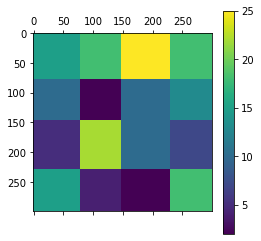

In [34]:
# P matrix
cax = plt.matshow(P)
plt.colorbar(cax)
plt.show()

In [6]:
d=K
# as rank(P) 

### Use the test with samples drawn from the same distribution - compared to one bootstrap from itself each time

In [38]:
# Generate more samples from the same model with the same parameters (P matrix)
random.seed(10)
np.random.seed(10)

M=200
A_true_draws = []

for m in range(M):
    # Generate random graph from the P matrix
    A_t = np.random.poisson(P_t)
    # turn to integer from float
    A_t = A_t.astype(float)
    As = A_t

    As = As.astype(float)

    A_true_draws.append(As)

In [40]:
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(10)
np.random.seed(10)
p_vals = []
A_boots_list = []

for m in A_true_draws:
    # create_single_bootstrap_weighted_poisson is a function that creates a single bootstrap sample for a weighted poisson model
    p_val, A_boots = create_single_bootstrap_weighted_poisson(m, d=d, Q=1000, n_neighbors=5)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

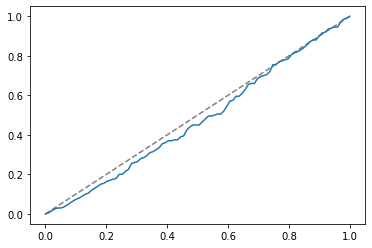

0.03

In [41]:
plot_power(p_vals, plot=True)

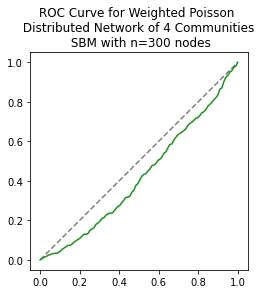

In [11]:
p_hat_list = p_vals
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title("ROC Curve for Weighted Poisson \n Distributed Network of 4 Communities \n SBM with n=300 nodes")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig("weighted_poission_n300_M200_Q1000_UASE_d4_curve.png")

plt.show()

No handles with labels found to put in legend.


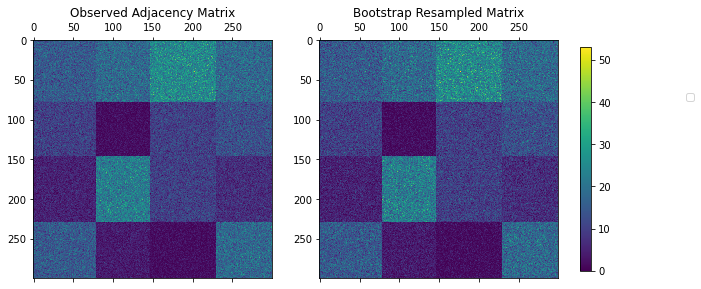

In [48]:
# Determine the min and max values across all matrices
vmin = min(A_true_draws[0].min(), A_boots_list[0].min())
vmax = max(A_true_draws[0].max(), A_boots_list[0].max())

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

# True replicates 
cax0 = ax0.matshow(A_true_draws[0], vmin=vmin, vmax=vmax)
ax0.set_title('Observed Adjacency Matrix')

# Bootstrap resampled matrix
cax1 = ax1.matshow(A_boots_list[0], vmin=vmin, vmax=vmax)
ax1.set_title('Bootstrap Resampled Matrix')

# Add colorbar for the figure
fig.colorbar(cax0, ax=[ax0, ax1], orientation='vertical', fraction=0.02, pad=0.04)

fig.legend(loc='upper right', bbox_to_anchor=(1.05, 0.7))

fig.savefig("weighted_poisson_n300_M200_Q1000_UASE_d4_heatmaps_firstObsAndBoots.png")
plt.show()


In [49]:
yhat_est = UASE([A_true_draws[0],A_boots_list[0]], d=K, flat=False)

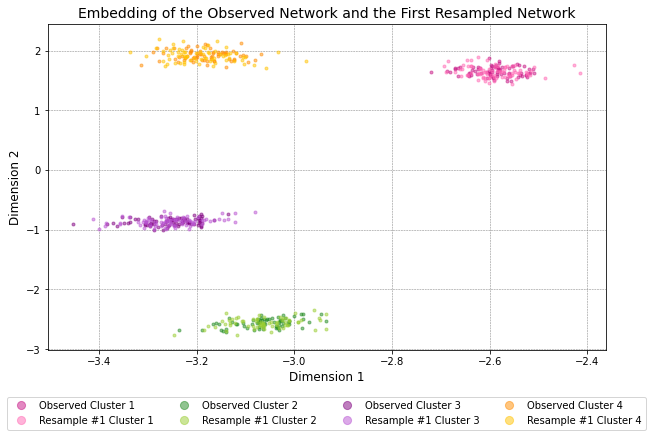

In [51]:
from matplotlib.colors import ListedColormap
cmap = plt.cm.get_cmap('Set2', K)  
cmap2 = plt.cm.get_cmap('Pastel2', K+1)  

# Define custom colors for the colormap
custom_colors = ['#C71585', '#228B22', '#800080', '#FF8C00']  # Example colors, you can adjust these
custom_colors2 = ['#FF69B4', '#9ACD32', '#BA55D3', '#FFC300']  

# Create a custom colormap using ListedColormap
custom_cmap = ListedColormap(custom_colors)
custom_cmap2 = ListedColormap(custom_colors2)

# Set the figure size
plt.figure(figsize=(10, 6))

# Now you can use custom_cmap in your plot
for i, label in enumerate(set(tau)):
    indices = [idx for idx, value in enumerate(tau) if value == label]
    plt.plot(yhat_est[0, indices, 0], yhat_est[0, indices, 1], 'o', alpha=0.5, label=f"Observed Cluster {label+1}", color=custom_cmap(i), markersize=3)
    plt.plot(yhat_est[1, indices, 0], yhat_est[1, indices, 1], 'o', alpha=0.5, label=f"Resample #1 Cluster {label+1}", color=custom_cmap2(i),markersize=3)

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.26), markerscale=2.7)

plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)

plt.title("Embedding of the Observed Network and the First Resampled Network", fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.5)  # Add gridlines

plt.savefig("weighted_poisson_n300_M200_Q1000_UASE_d4_embedding_firstObsAndBoots.png")

plt.show()

#### Not an SBM structure, just random, for the weighed poisson

In [3]:
# Network generation --------------------------------------------------------
n = 1000  # number of nodes

random.seed(100)
np.random.seed(100)

# Get lambda matrix random
P_list = []
P_t = np.random.randint(1, 20, size=(n,n))

P_list.append(P_t)

P = np.column_stack(P_list)

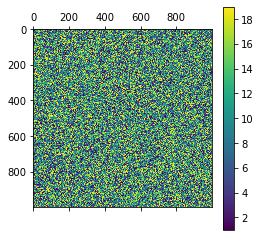

In [4]:
# P matrix
cax = plt.matshow(P)
plt.colorbar(cax)
plt.show()

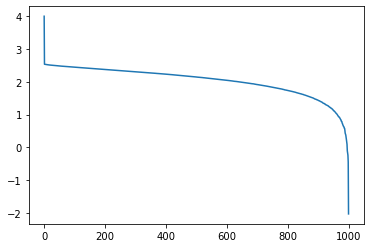

In [5]:
# do a svd on P_t
u, s, v = np.linalg.svd(P_t)
# plot the singular values in decreasing order
plt.plot(np.log10(s))

### Use the test with samples drawn from the same distribution - compared to one bootstrap from itself each time

In [6]:
# Generate more samples from the same model with the same parameters (P matrix)
random.seed(10)
np.random.seed(10)

M=300
A_true_draws = []

for m in range(M):
    # Generate random graph from the P matrix
    A_t = np.random.poisson(P_t)
    # turn to integer from float
    A_t = A_t.astype(float)
    As = A_t

    As = As.astype(float)

    A_true_draws.append(As)

In [7]:
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(10)
np.random.seed(10)
p_vals = []
A_boots_list = []

for m in A_true_draws:
    # create_single_bootstrap_weighted_poisson is a function that creates a single bootstrap sample for a weighted poisson model
    p_val, A_boots = create_single_bootstrap_weighted_poisson(m, d=4, Q=1000, n_neighbors=5)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

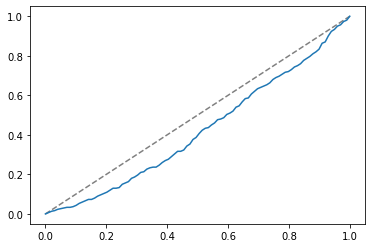

0.02666666666666667

In [8]:
plot_power(p_vals, plot=True)

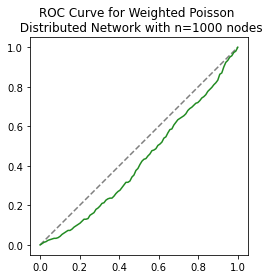

In [13]:
p_hat_list = p_vals
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title("ROC Curve for Weighted Poisson \n Distributed Network with n=1000 nodes")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig("weighted_poission_n1000_M300_Q1000_UASE_d4_curve.png")

plt.show()

Playing about with the value of n and the range that the values of lambda in the lambda matrix take, it appears you never get the values going as high as for the true things, i.e. the replication method is conservative 

No handles with labels found to put in legend.


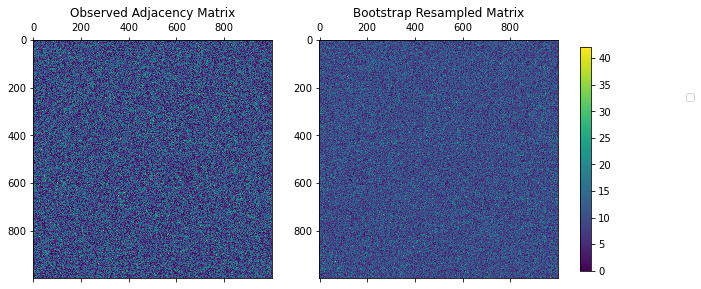

In [14]:
# Determine the min and max values across all matrices
vmin = min(A_true_draws[0].min(), A_boots_list[0].min())
vmax = max(A_true_draws[0].max(), A_boots_list[0].max())

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

# True replicates 
cax0 = ax0.matshow(A_true_draws[0], vmin=vmin, vmax=vmax)
ax0.set_title('Observed Adjacency Matrix')

# Bootstrap resampled matrix
cax1 = ax1.matshow(A_boots_list[0], vmin=vmin, vmax=vmax)
ax1.set_title('Bootstrap Resampled Matrix')

# Add colorbar for the figure
fig.colorbar(cax0, ax=[ax0, ax1], orientation='vertical', fraction=0.02, pad=0.04)

fig.legend(loc='upper right', bbox_to_anchor=(1.05, 0.7))

fig.savefig("weighted_poisson_n1000_M300_Q1000_UASE_d4_heatmaps_firstObsAndBoots.png")
plt.show()


In [19]:
yhat_est = UASE([A_true_draws[0],A_boots_list[0]], d=4, flat=False)

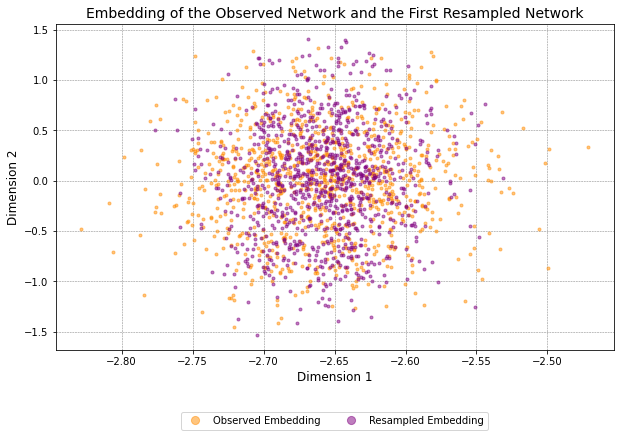

In [28]:
from matplotlib.colors import ListedColormap

# Define custom colors for the colormap
custom_colors = ['#C71585', '#228B22', '#800080', '#FF8C00']  # Example colors, you can adjust these
custom_colors2 = ['#FF69B4', '#9ACD32', '#BA55D3', '#FFC300']  

# Create a custom colormap using ListedColormap
custom_cmap = ListedColormap(custom_colors)
custom_cmap2 = ListedColormap(custom_colors2)

# Set the figure size
plt.figure(figsize=(10, 6))

tau = np.ones(n)

# Now you can use custom_cmap in your plot
for i, label in enumerate(set(tau)):
    indices = [idx for idx, value in enumerate(tau) if value == label]
    plt.plot(yhat_est[0, indices, 0], yhat_est[0, indices, 1], 'o', alpha=0.5, label=f"Observed Embedding", color=custom_cmap(i+3), markersize=3)
    plt.plot(yhat_est[1, indices, 0], yhat_est[1, indices, 1], 'o', alpha=0.5, label=f"Resampled Embedding", color=custom_cmap(i+2),markersize=3)

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.26), markerscale=2.7)

plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)

plt.title("Embedding of the Observed Network and the First Resampled Network", fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.5)  # Add gridlines

plt.savefig("weighted_poisson_n1000_M300_Q1000_UASE_d4_embedding_firstObsAndBoots.png")

plt.show()